In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
sys.path.append('../')

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from data.load import get_patched_data, get_patched_src, subsample
from data.utils import custom_cutout
from model.metrics import psnr, ssim

## Choose Devices

In [6]:
gpu_id = 3
num_cores = 4

In [7]:
torch.cuda.set_device(gpu_id)

## Set Experiment Name

In [25]:
nb_name = 'critic_patches_resnet_pretrained'

## Load Data

In [10]:
bs = 8  # batch size
size = 256  # image size
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF')  # path to dataset
lr_dir = f'EM/training/trainsets/lr/'  # input images
hr_dir = f'EM/training/trainsets/hr/'  # target images
model_pth = data_pth/f'EM/models/critics'  # path to saved models
print(data_pth)  # confirm data path
print(model_pth) # confirm model path

/home/alaa/Dropbox/BPHO Staff/USF
/home/alaa/Dropbox/BPHO Staff/USF/EM/models/critics


In [11]:
random_patch = partial(custom_cutout, min_n_holes=10, max_n_holes=20,
                       min_length=15, max_length=25, use_on_y=False)

In [12]:
tfms = [[random_patch()], [random_patch()]]

In [13]:
tfms

[[RandTransform(tfm=TfmPixel (custom_cutout), kwargs={'min_n_holes': 10, 'max_n_holes': 20, 'min_length': 15, 'max_length': 25}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=False)],
 [RandTransform(tfm=TfmPixel (custom_cutout), kwargs={'min_n_holes': 10, 'max_n_holes': 20, 'min_length': 15, 'max_length': 25}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=False)]]

In [14]:
# Create databunch
data = get_patched_data(data_pth, hr_dir, bs, tfms=tfms,
                        in_sz=size, out_sz=size)

In [15]:
# Dataset sizes
len(data.train_ds), len(data.valid_ds)

(79998, 19999)

In [16]:
# Batch size and number of batches
data.batch_size, len(data.train_dl)

(8, 9999)

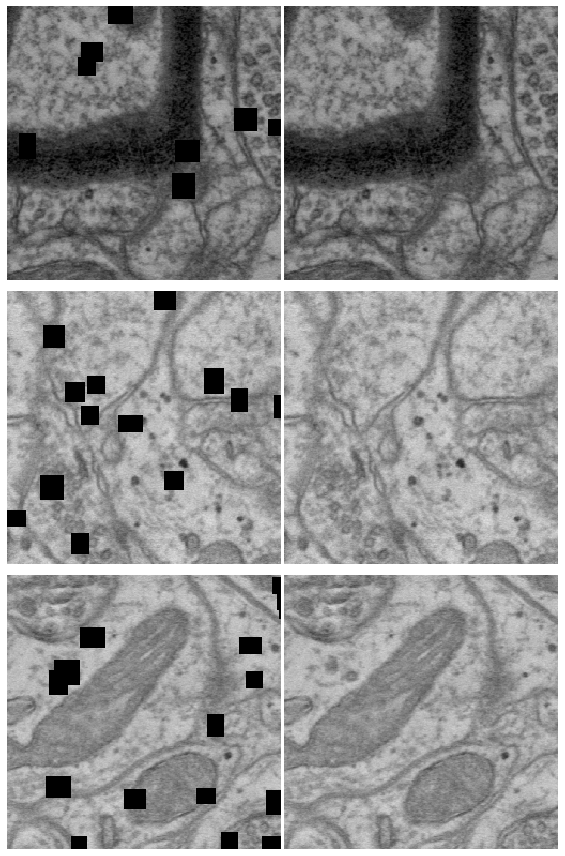

In [17]:
# Data Visualization
data.show_batch(rows=3)

## Data Subsample

In [18]:
data = subsample(data)

In [19]:
data.c

3

In [20]:
# Dataset sizes
len(data.train_dl), len(data.valid_dl)

(999, 250)

In [21]:
# Batch size and number of batches
data.batch_size

8

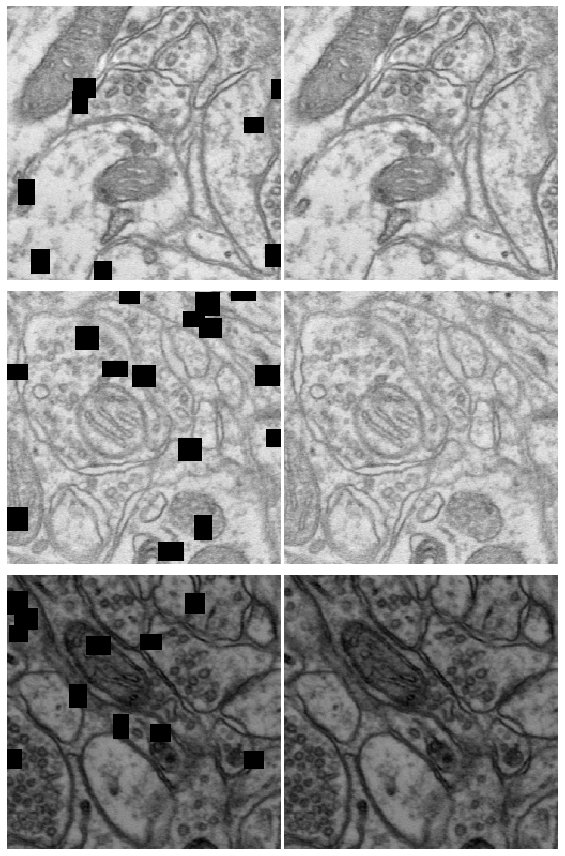

In [22]:
# Data Visualization
data.show_batch(rows=3)

# Model

## Initialization

In [23]:
arch = models.resnet34
wd = 1e-3
metrics = [F.mse_loss, psnr, ssim]
learn = unet_learner(data, arch, wd=wd, 
                         #loss_func=feat_loss,
                         loss_func=F.mse_loss,
                         metrics=metrics, 
                         #callback_fns=LossMetrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_pth)
gc.collect()

25516

In [24]:
learn.model_dir = model_pth
print(learn.model_dir)

/home/alaa/Dropbox/BPHO Staff/USF/EM/models/critics


## Load Model

In [27]:
# learn.model_dir = model_pth
learn = learn.load(f'{nb_name}.2g')

In [68]:
lr = 1e-3
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2g', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.007513,0.006041,0.006041,22.260235,0.957944,03:18
1,0.005584,0.004927,0.004927,23.144451,0.962574,03:19
2,0.005250,0.004758,0.004758,23.290270,0.962920,03:21


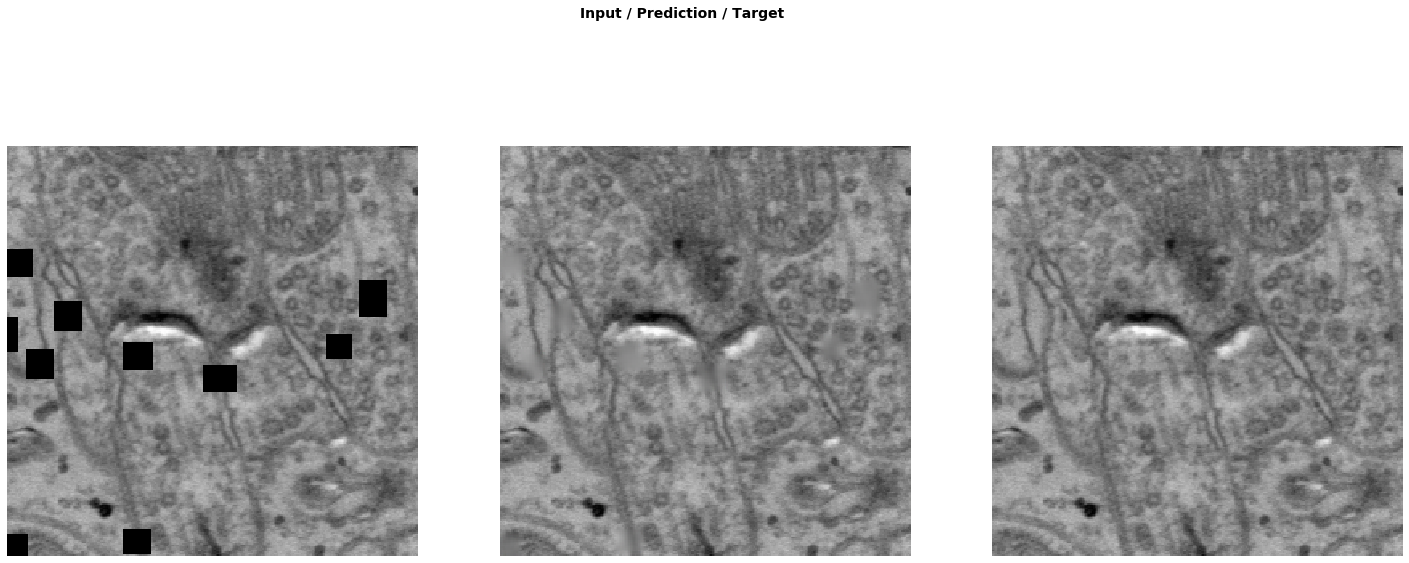

In [71]:
learn.show_results(rows=1, figsize=(25, 10))

## Heatmap

In [ ]:
from fastai.callbacks.hooks import *

In [28]:
m = learn.model.eval()

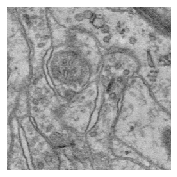

In [128]:
idx=6
x,y = data.valid_ds[idx]
y.show()
xb,_ = data.one_item(y)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [164]:
m

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

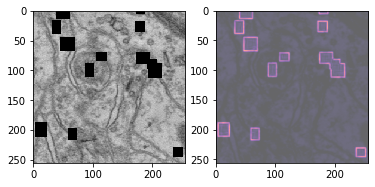

In [169]:
def hooked_backward(cat=y):
    with hook_output(m[10][1][0]) as hook_a: 
        with hook_output(m[10][1][0], grad=True) as hook_g:
            preds = m(xb)
#             preds[0].backward()
    return hook_a,hook_g

hook_a,hook_g = hooked_backward()

acts  = hook_a.stored[0].cpu()

avg_acts = acts.mean(0)

def show_heatmap(hm):
    _,ax = plt.subplots(1,2)
    ax[0].imshow(xb_im.data.permute(1,2,0))
    ax[1].imshow(hm, alpha=0.6, extent=(0,256,256,0),
              interpolation='bilinear', cmap='magma');

show_heatmap(avg_acts)

# DEV

In [40]:
from fastai.vision import *
def get_patched_data(data_pth, hr_dir, bs, in_sz, out_sz,
                     tfms=None, num_workers=4, noise=None, max_zoom=1.1):
    src = get_patched_src(data_pth, hr_dir)
    
    data = (src
                .transform(tfms, size=in_sz, resize_method=ResizeMethod.CROP)
                .transform_y(None, size=out_sz, resize_method=ResizeMethod.CROP)
                .databunch(bs=bs, num_workers=num_workers)
                .normalize(imagenet_stats, do_y=True))
    data.c = 3
    data.train_ds.tfms_y = None
    return data


def get_patched_src(data_pth, hr_dir):
    hr_tifs = data_pth/f'{hr_dir}'

    def map_to_hr(x):
        return hr_tifs/x.relative_to(hr_tifs).with_suffix(".tif")

    src = (ImageImageList
            .from_folder(hr_tifs)
            .split_by_rand_pct()
            .label_from_func(map_to_hr))
    return src